# Fast.ai PyTorch Caltech 256 deployment  

## Pre-requisites

This notebook shows how to use the SageMaker Python SDK to take your existing trained fast.ai model in a local container before deploying to SageMaker's managed hosting environments based on the PyTorch framework.  This can speed up iterative testing and debugging while using the same familiar Python SDK interface.  Just change your estimator's `instance_type` to `local`.

In order to use this feature you'll need to install docker-compose (and nvidia-docker if training with a GPU).

**Note, you can only run a single local notebook at one time.**

In [1]:
!/bin/bash ./setup.sh

SageMaker instance route table setup is ok. We are good to go.
SageMaker instance routing for Docker is ok. We are good to go!


## Overview

The **SageMaker Python SDK** helps you deploy your models for training and hosting in optimized, productions ready containers in SageMaker. The SageMaker Python SDK is easy to use, modular, extensible and compatible with TensorFlow, MXNet, PyTorch and Chainer. This tutorial focuses on how to take an existing pretrained fast.ai based convulutional neural network trained on the Caltech 256 dataset (http://www.vision.caltech.edu/Image_Datasets/Caltech256/) using **PyTorch in local mode**.

### Set up the environment

This notebook was created and tested on a single ml.m4.xlarge notebook instance.

Let's start by specifying:

- The S3 Bucket where the model data is stored. 
- The Model Data prefix which is the S3 prefix to the zipped model. Must contain the weights of the fast.ai model saved with .h5 extension. Model tarball must also contain a file called `classes.json` containing list of the class names used for classification.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the sagemaker.get_execution_role() with appropriate full IAM role arn string(s).

In [2]:
import sagemaker
import boto3

region = boto3.session.Session().region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')

bucket = 'sagemaker-{}-{}'.format(account_id, region)
model_data_prefix='models/caltech256_fastai_sagemaker/model.tar.gz'

model_data_url=f's3://{bucket}/{model_data_prefix}'
print(f'Model Data URL is: {model_data}')

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

## Host
### Hosting script
We are going to provide custom implementation of `model_fn`, `input_fn`, `output_fn` and `predict_fn` hosting functions in a separate file:

In [ ]:
!pygmentize 'source/app.py'

### Import model into SageMaker
The PyTorch model uses a npy serializer and deserializer by default. For this example, since we have a custom implementation of all the hosting functions and plan on using a byte based input and JSON output, we need a predictor that can deserialize JSON.

In [3]:
from sagemaker.predictor import RealTimePredictor, json_deserializer

class ImagePredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(endpoint_name, sagemaker_session=sagemaker_session, serializer=None, 
                                            deserializer=json_deserializer, content_type='image/jpeg')

To deploy the model either locally or as a SageMaker Endpoint we need to create a PyTorchModel object using the latest training job to get the S3 location of the trained model data. Besides model data location in S3, we also need to configure PyTorchModel with the script and source directory (because our `app` script requires fast.ai model classes from source directory), an IAM role.

In [4]:
from sagemaker.pytorch import PyTorchModel

# Configure an PyTorch Model
pytorch_model = PyTorchModel(model_data=model_data_url, 
                                source_dir='source',
                                entry_point='app.py',
                                role=role,
                                predictor_cls=ImagePredictor)

### Create endpoint

Now the model is ready to be deployed at a SageMaker endpoint and we are going to use the `sagemaker.pytorch.model.PyTorchModel.deploy` method to do this. We can set the value of instance type to `local` if we want to deploy and test locally on our notebook instance. Once you have tested it out locallyed we can deploy as a SageMaker endpoint using a CPU-based instance for inference (e.g. ml.m4.xlarge), even though the model may have been trained on GPU instances.

In [5]:
#instance_type='local'
instance_type='ml.m4.xlarge'

In [6]:
# In Local Mode, fit will pull the PyTorch container docker image and run it locally
predictor = pytorch_model.deploy(instance_type=instance_type, initial_instance_count=1)

INFO:sagemaker:Creating model with name: sagemaker-pytorch-2018-06-29-09-05-11-364
INFO:sagemaker:Creating endpoint with name sagemaker-pytorch-2018-06-29-09-05-11-364


--------------------------------------------------------------!

### Evaluate
We are going to use our deployed model to do object classification based on a submitted image.

In [7]:
import io
import requests
from PIL import Image

Enter the URL of an image from the from the site: http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/

In [11]:
#IMG_URL='http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/010.beer-mug/010_0011.jpg'
IMG_URL='http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/002.american-flag/002_0019.jpg'
#IMG_URL='http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/038.chimp/038_0009.jpg'

Let's download the image from the URL and display the image.

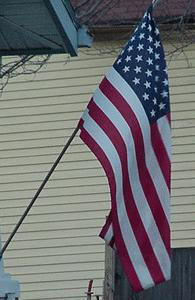

In [12]:
response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))
img_pil

Now we will call the prediction endpoint.

In [13]:
# Serializes data and makes a prediction request to the endpoint (local or sagemaker)
response = predictor.predict(response.content)
response

{'class': '002.american-flag', 'confidence': 0.9999979734420776}

### Cleanup

After you have finished with this example, remember to delete the prediction endpoint to release the instance(s) associated with it.

In [ ]:
sagemaker_session.delete_endpoint(predictor.endpoint)